In [1]:
import numpy as np
import pandas as pd
import torch
from torch.amp import autocast
import matplotlib.pyplot as plt
import time
import os
import json
from sklearn.linear_model import LinearRegression

# ------------------------- Device Configuration -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[System] Current device: {device}\n")

[System] Current device: cuda



In [2]:
# ------------------------- Quantum Operation Functions -------------------------
def generate_spin_ops(n_qubits, device):
    """Generate X and Z operators for multiple qubits (explicitly using complex64)"""
    SX = torch.tensor([[0, 1], [1, 0]], dtype=torch.complex64, device=device)
    SZ = torch.tensor([[1, 0], [0, -1]], dtype=torch.complex64, device=device)
    X_ops, Z_ops = {}, {}
    for idx in range(1, n_qubits + 1):
        dim_left = 2 ** (idx - 1)
        dim_right = 2 ** (n_qubits - idx)
        left_eye = torch.eye(dim_left, dtype=torch.complex64, device=device)
        right_eye = torch.eye(dim_right, dtype=torch.complex64, device=device)
        X_ops[idx] = torch.kron(torch.kron(left_eye, SX), right_eye)
        Z_ops[idx] = torch.kron(torch.kron(left_eye, SZ), right_eye)
    return X_ops, Z_ops

In [3]:
def partial_trace(dm, n_trace, keep_first=False):
    """Partial trace calculation (type-agnostic)"""
    batch_size = dm.shape[0]
    total_dim = dm.shape[1]
    trace_dim = 2 ** n_trace
    keep_dim = total_dim // trace_dim
    if keep_first:
        dm_reshaped = dm.view(batch_size, keep_dim, trace_dim, keep_dim, trace_dim)
        return torch.einsum('...baca->...bc', dm_reshaped)
    else:
        dm_reshaped = dm.view(batch_size, trace_dim, keep_dim, trace_dim, keep_dim)
        return torch.einsum('...abac->...bc', dm_reshaped)

In [4]:
def measure_z_batch(rhos, g, N, device):
    """Z-basis measurement (with automatic mixed precision)"""
    with autocast(device_type='cuda' if device.type == 'cuda' else 'cpu'):
        batch_size, dim, _ = rhos.shape
        diag_probs = torch.diagonal(rhos, dim1=-2, dim2=-1).real
        diag_probs = torch.clamp(diag_probs, min=0.0)
        diag_probs /= diag_probs.sum(dim=1, keepdim=True)
        ks = torch.multinomial(diag_probs, num_samples=1, replacement=True).squeeze(1)
        shift = torch.arange(N - 1, -1, -1, device=device, dtype=torch.int32)
        bits = (ks.unsqueeze(1) >> shift) & 1
        mean = (2 * bits - 1).float() * g
        V_batch = torch.normal(mean=mean, std=1.0)
        f0 = torch.exp(-((V_batch - g) ** 2) / 4)
        f1 = torch.exp(-((V_batch + g) ** 2) / 4)
        f = torch.stack([f0, f1], dim=2)
        omega = f[:, 0].view(batch_size, 2)
        for n in range(1, N):
            omega = omega.unsqueeze(2) * f[:, n].unsqueeze(1)
            omega = omega.reshape(batch_size, -1)
        omega = omega.view(batch_size, dim)
        rhos = rhos * omega[:, :, None] * omega[:, None, :]
        norm = torch.einsum('rii->r', rhos).real.view(-1, 1, 1).clamp(min=1e-8)
        rhos = rhos / norm
    return rhos, V_batch

In [5]:
def gen_basis_change_mats(total_spins, device):
    """Generate basis transformation matrices from X/Y to Z basis (explicitly using complex64)"""
    H1 = (1 / torch.sqrt(torch.tensor(2, device=device, dtype=torch.float32))).to(torch.complex64)
    H1 = H1 * torch.tensor([[1, 1], [1, -1]], dtype=torch.complex64, device=device)
    Sdg1 = torch.tensor([[1, 0], [0, 1j]], dtype=torch.complex64, device=device)
    H_tot, Sdg_tot = H1, Sdg1
    for _ in range(total_spins - 1):
        H_tot = torch.kron(H_tot, H1)
        Sdg_tot = torch.kron(Sdg_tot, Sdg1)
    X_change = H_tot
    Y_change = H_tot @ Sdg_tot
    return X_change, Y_change, X_change.conj().T, Y_change.conj().T

In [6]:
def build_hamiltonian(total_spins, H_field, J_base, device):
    """Construct Hamiltonian (explicitly using complex64)"""
    X_ops, Z_ops = generate_spin_ops(total_spins, device)
    dim = 2 ** total_spins
    H = torch.zeros((dim, dim), dtype=torch.complex64, device=device)
    for i in range(1, total_spins + 1):
        H += 0.5 * H_field * Z_ops[i]
    J_num = total_spins * (total_spins - 1) // 2
    J_vals = (torch.rand(J_num, device=device) - 0.5) * 2 * J_base
    idx = 0
    for i in range(1, total_spins + 1):
        for j in range(i + 1, total_spins + 1):
            H += J_vals[idx] * (X_ops[i] @ X_ops[j])
            idx += 1
    return H

In [7]:
def compute_time_evolution(H, T_evolution, device):
    """Compute time evolution operator U=exp(-iHT) (pure PyTorch implementation with GPU acceleration)"""
    i = torch.tensor(1j, dtype=torch.complex64, device=device)  # Imaginary unit i
    exponent = -i * H * T_evolution  # Compute exponent term -iHT
    U = torch.matrix_exp(exponent)  # PyTorch matrix exponential (GPU-accelerated)
    return U, U.conj().T  # U_dag is the conjugate transpose of U

In [8]:
def add_markov_features(df, suffix="_M"):
    """Add Markov features (product of current features and previous timestep)"""
    prev = df.shift(1, fill_value=0).values
    markov = prev * df.values
    df_markov = pd.DataFrame(markov, columns=[f"{col}{suffix}" for col in df.columns], index=df.index)
    return pd.concat([df, df_markov], axis=1)

In [9]:
def compute_capacity(features_df, time_series, eta, f_p):
    """Calculate prediction capacity (R² coefficient)"""
    N_skip = 20
    features_df = features_df.iloc[N_skip:].reset_index(drop=True)
    time_series = time_series[N_skip:]
    X_all = features_df.values.astype(float)
    eta = abs(eta)
    if f_p:
        Y_all = np.expand_dims(time_series[eta:], axis=1)
        X_all = X_all[:-eta]
    else:
        Y_all = np.expand_dims(time_series[:-eta], axis=1)
        X_all = X_all[eta:]
    N_total = len(Y_all)
    N_train = int(0.7 * N_total)
    X_train, y_train = X_all[:N_train], Y_all[:N_train]
    X_test, y_test = X_all[N_train:], Y_all[N_train:]
    model = LinearRegression().fit(X_train, y_train)
    y_train_pred = model.predict(X_train).ravel()
    y_test_pred = model.predict(X_test).ravel()
    r_train = np.corrcoef(y_train.ravel(), y_train_pred)[0, 1]
    r_test = np.corrcoef(y_test.ravel(), y_test_pred)[0, 1]
    return r_train ** 2, r_test ** 2

In [10]:
# ========================== Core Simulation Function (No Timestep Logging) ==========================
def simulate_features_xyz_OLP(nb_runs_total, g, U, U_dag, time_series, total_spins, add_markov, device, batch_size=1000):
    T = len(time_series)
    dim = 2 ** total_spins
    Xc, Yc, Xc_dag, Yc_dag = gen_basis_change_mats(total_spins, device)

    # Initialize global statistics
    sum_V_total = torch.zeros((3, T, total_spins), dtype=torch.float32, device=device)
    sum_VV_total = torch.zeros((3, T, total_spins, total_spins), dtype=torch.float32, device=device)

    num_batches = (nb_runs_total + batch_size - 1) // batch_size
    print(f"[Simulation] g={g:.1f}, total_runs={nb_runs_total}, batches={num_batches}")

    for batch_idx in range(num_batches):
        batch_start = time.time()
        current_runs = min(batch_size, nb_runs_total - batch_idx * batch_size)
        print(f"  Batch {batch_idx + 1}/{num_batches}: {current_runs} runs")

        # Initialize batch states
        rho0 = torch.zeros((dim, dim), dtype=torch.complex64, device=device)
        rho0[0, 0] = 1.0
        rhos = rho0.unsqueeze(0).repeat(current_runs, 1, 1)
        time_series_tensor = torch.tensor(time_series, dtype=torch.float32, device=device)

        # Batch statistics
        sum_V_batch = torch.zeros((3, T, total_spins), dtype=torch.float32, device=device)
        sum_VV_batch = torch.zeros((3, T, total_spins, total_spins), dtype=torch.float32, device=device)

        # Time loop (no timestep logging)
        for t in range(T):
            s_k = time_series_tensor[t]
            rho_A = torch.tensor([[1 - s_k, torch.sqrt((1 - s_k) * s_k)],
                                  [torch.sqrt((1 - s_k) * s_k), s_k]], dtype=torch.complex64, device=device)
            rho_Bs = partial_trace(rhos, n_trace=1, keep_first=False)
            rhos = torch.einsum('ab, rcd -> racbd', rho_A, rho_Bs).view(current_runs, dim, dim)
            rhos_pre = rhos.clone()
            rhos = U @ rhos @ U_dag

            # Measurement logic (no logging)
            with autocast(device_type='cuda' if device.type == 'cuda' else 'cpu'):
                # Z-basis measurement
                rhos, Vz = measure_z_batch(rhos, g, total_spins, device)
                sum_V_batch[0, t] += Vz.mean(dim=0)
                sum_VV_batch[0, t] += torch.cov(Vz.T)

                # X-basis measurement
                rhos_X = Xc @ rhos_pre @ Xc_dag
                _, Vx = measure_z_batch(rhos_X, g, total_spins, device)
                sum_V_batch[1, t] += Vx.mean(dim=0)
                sum_VV_batch[1, t] += torch.cov(Vx.T)

                # Y-basis measurement
                rhos_Y = Yc @ rhos_pre @ Yc_dag
                _, Vy = measure_z_batch(rhos_Y, g, total_spins, device)
                sum_V_batch[2, t] += Vy.mean(dim=0)
                sum_VV_batch[2, t] += torch.cov(Vy.T)

        # Accumulate batch statistics
        sum_V_total += sum_V_batch * current_runs
        sum_VV_total += sum_VV_batch * current_runs

        # Free GPU memory
        del rhos, rho0, rhos_pre, rho_Bs, rhos_X, rhos_Y
        if device.type == 'cuda':
            torch.cuda.empty_cache()

        # Batch completion log
        batch_duration = time.time() - batch_start
        print(f"  Batch {batch_idx + 1}/{num_batches} done in {batch_duration:.2f}s")

    # Compute final statistics
    sum_V_total /= nb_runs_total
    sum_VV_total = (sum_VV_total / nb_runs_total) - (sum_V_total.unsqueeze(-1) @ sum_V_total.unsqueeze(-2))

    # Assemble features
    sum_V = sum_V_total.cpu().numpy()
    sum_VV = sum_VV_total.cpu().numpy()
    i_up, j_up = np.triu_indices(total_spins, k=1)
    features = []
    for idx_dir in range(3):
        mean_V = sum_V[idx_dir]
        cov_V = sum_VV[idx_dir][:, i_up, j_up]
        features.append(np.hstack([mean_V, cov_V]))
    data = np.hstack(features)
    base_df = pd.DataFrame(data)
    if add_markov:
        base_df = add_markov_features(base_df)
    return base_df

In [10]:
# ========================== Core Simulation Function (No Timestep Logging) ==========================
def simulate_features_xyz_RWP(nb_runs_total, burntime, U, U_dag, time_series, total_spins, add_markov, device, batch_size=1000):
    T = len(time_series)
    dim = 2 ** total_spins
    Xc, Yc, Xc_dag, Yc_dag = gen_basis_change_mats(total_spins, device)

    # Initialize global statistics
    sum_V_total = torch.zeros((3, T, total_spins), dtype=torch.float32, device=device)
    sum_VV_total = torch.zeros((3, T, total_spins, total_spins), dtype=torch.float32, device=device)

    num_batches = (nb_runs_total + batch_size - 1) // batch_size
    print(f"[Simulation] g={g:.1f}, total_runs={nb_runs_total}, batches={num_batches}")

    for batch_idx in range(num_batches):
        batch_start = time.time()
        current_runs = min(batch_size, nb_runs_total - batch_idx * batch_size)
        print(f"  Batch {batch_idx + 1}/{num_batches}: {current_runs} runs")

        # Initialize batch states
        rho0 = torch.zeros((dim, dim), dtype=torch.complex64, device=device)
        rho0[0, 0] = 1.0
        rhos = rho0.unsqueeze(0).repeat(current_runs, 1, 1)
        time_series_tensor = torch.tensor(time_series, dtype=torch.float32, device=device)

        # Batch statistics
        sum_V_batch = torch.zeros((3, T, total_spins), dtype=torch.float32, device=device)
        sum_VV_batch = torch.zeros((3, T, total_spins, total_spins), dtype=torch.float32, device=device)

        # Time loop (no timestep logging)
        for t in range(T):
            s_k = time_series_tensor[t]
            rho_A = torch.tensor([[1 - s_k, torch.sqrt((1 - s_k) * s_k)],
                                  [torch.sqrt((1 - s_k) * s_k), s_k]], dtype=torch.complex64, device=device)
            rho_Bs = partial_trace(rhos, n_trace=1, keep_first=False)
            rhos = torch.einsum('ab, rcd -> racbd', rho_A, rho_Bs).view(current_runs, dim, dim)
            rhos_pre = rhos.clone()
            rhos = U @ rhos @ U_dag

            # Measurement logic (no logging)
            with autocast(device_type='cuda' if device.type == 'cuda' else 'cpu'):
                # Z-basis measurement
                rhos, Vz = measure_z_batch(rhos, g, total_spins, device)
                sum_V_batch[0, t] += Vz.mean(dim=0)
                sum_VV_batch[0, t] += torch.cov(Vz.T)

                # X-basis measurement
                rhos_X = Xc @ rhos_pre @ Xc_dag
                _, Vx = measure_z_batch(rhos_X, g, total_spins, device)
                sum_V_batch[1, t] += Vx.mean(dim=0)
                sum_VV_batch[1, t] += torch.cov(Vx.T)

                # Y-basis measurement
                rhos_Y = Yc @ rhos_pre @ Yc_dag
                _, Vy = measure_z_batch(rhos_Y, g, total_spins, device)
                sum_V_batch[2, t] += Vy.mean(dim=0)
                sum_VV_batch[2, t] += torch.cov(Vy.T)

        # Accumulate batch statistics
        sum_V_total += sum_V_batch * current_runs
        sum_VV_total += sum_VV_batch * current_runs

        # Free GPU memory
        del rhos, rho0, rhos_pre, rho_Bs, rhos_X, rhos_Y
        if device.type == 'cuda':
            torch.cuda.empty_cache()

        # Batch completion log
        batch_duration = time.time() - batch_start
        print(f"  Batch {batch_idx + 1}/{num_batches} done in {batch_duration:.2f}s")

    # Compute final statistics
    sum_V_total /= nb_runs_total
    sum_VV_total = (sum_VV_total / nb_runs_total) - (sum_V_total.unsqueeze(-1) @ sum_V_total.unsqueeze(-2))

    # Assemble features
    sum_V = sum_V_total.cpu().numpy()
    sum_VV = sum_VV_total.cpu().numpy()
    i_up, j_up = np.triu_indices(total_spins, k=1)
    features = []
    for idx_dir in range(3):
        mean_V = sum_V[idx_dir]
        cov_V = sum_VV[idx_dir][:, i_up, j_up]
        features.append(np.hstack([mean_V, cov_V]))
    data = np.hstack(features)
    base_df = pd.DataFrame(data)
    if add_markov:
        base_df = add_markov_features(base_df)
    return base_df

In [11]:
# Parameter configuration
TOTAL_SPINS = 6
H_FIELD = 10.0
J_BASE = 1.0
T_EVOLUTION = 10.0
ADD_MARKOV = True
TOTAL_RUNS = 5000000
BATCH_SIZE = 1000

# Create results directory (with timestamp to avoid overwrites)
timestamp = time.strftime("%Y%m%d_%H%M%S")
output_dir = f"results_{timestamp}"
os.makedirs(output_dir, exist_ok=True)
print(f"[System] Results will be saved to directory: {output_dir}\n")

# Load time series (use random data as fallback)
TS_RAW = np.load("sk_Santa_Fe_2000.npy")
ts_min, ts_max = TS_RAW.min(), TS_RAW.max()
TIME_SERIES = ((TS_RAW + abs(ts_min)) / (ts_max - ts_min)).flatten()

# Build Hamiltonian and time evolution operator (using PyTorch)
H = build_hamiltonian(TOTAL_SPINS, H_FIELD, J_BASE, device)
U, U_dag = compute_time_evolution(H, T_EVOLUTION, device)

[System] Results will be saved to directory: results_20250531_223909



In [12]:
# Define simulation tasks (covering 4 curves)
simulation_tasks = [
    (TOTAL_RUNS, 0.8, "feats_g08_R100"),
    (TOTAL_RUNS, 0.2, "feats_g02_R100"),
    (TOTAL_RUNS // 2, 0.8, "feats_g08_R50"),
    (TOTAL_RUNS // 2, 0.2, "feats_g02_R50"),
    (int(0.75 * TOTAL_RUNS), 0.8, "feats_g08_R75"),
    (int(0.25 * TOTAL_RUNS), 0.2, "feats_g02_R25")
]

# Execute simulation tasks (with immediate saving)
results = {}
print("\n===== Starting All Simulation Tasks =====")
start_time = time.time()
for runs, g_val, task_name in simulation_tasks:
    try:
        print(f"\n===== Starting task: {task_name} (runs={runs}, g={g_val}) =====")
        task_start = time.time()

        features = simulate_features_xyz(
            nb_runs_total=runs,
            g=g_val,
            U=U,
            U_dag=U_dag,
            time_series=TIME_SERIES,
            total_spins=TOTAL_SPINS,
            add_markov=ADD_MARKOV,
            device=device,
            batch_size=BATCH_SIZE
        )

        save_path = os.path.join(output_dir, f"{task_name}.csv")
        features.to_csv(save_path, index=False)
        print(f"[Success] Task {task_name} features saved to: {save_path}")

        results[task_name] = features

        task_duration = time.time() - task_start
        print(f"Task {task_name} completed in {task_duration:.2f} seconds")
    except Exception as e:
        print(f"Task {task_name} failed: {e}")
        continue

# Merge features (for curves 3 and 4)
print("\n===== Merging Features (for Curves 3 & 4) =====")
merged_features = {}
if "feats_g08_R50" in results and "feats_g02_R50" in results:
    merged_50_50 = pd.concat([results["feats_g08_R50"], results["feats_g02_R50"]], axis=1)
    merged_features["mixed_50_08_50_02"] = merged_50_50
    merged_50_50_path = os.path.join(output_dir, "mixed_50_08_50_02.csv")
    merged_50_50.to_csv(merged_50_50_path, index=False)
    print(f"[Success] Curve 3 features saved to: {merged_50_50_path}")
else:
    print("Warning: Missing 'feats_g08_R50' or 'feats_g02_R50', skipping Curve 3")

if "feats_g08_R75" in results and "feats_g02_R25" in results:
    merged_75_25 = pd.concat([results["feats_g08_R75"], results["feats_g02_R25"]], axis=1)
    merged_features["mixed_75_08_25_02"] = merged_75_25
    merged_75_25_path = os.path.join(output_dir, "mixed_75_08_25_02.csv")
    merged_75_25.to_csv(merged_75_25_path, index=False)
    print(f"[Success] Curve 4 features saved to: {merged_75_25_path}")
else:
    print("Warning: Missing 'feats_g08_R75' or 'feats_g02_R25', skipping Curve 4")


===== Starting All Simulation Tasks =====

===== Starting task: feats_g08_R100 (runs=5000000, g=0.8) =====
[Simulation] g=0.8, total_runs=5000000, batches=5000
  Batch 1/5000: 1000 runs
  Batch 1/5000 done in 5.51s
  Batch 2/5000: 1000 runs
  Batch 2/5000 done in 5.40s
  Batch 3/5000: 1000 runs
  Batch 3/5000 done in 5.41s
  Batch 4/5000: 1000 runs
  Batch 4/5000 done in 5.41s
  Batch 5/5000: 1000 runs
  Batch 5/5000 done in 5.42s
  Batch 6/5000: 1000 runs
  Batch 6/5000 done in 5.42s
  Batch 7/5000: 1000 runs
  Batch 7/5000 done in 5.42s
  Batch 8/5000: 1000 runs
  Batch 8/5000 done in 5.42s
  Batch 9/5000: 1000 runs
  Batch 9/5000 done in 5.42s
  Batch 10/5000: 1000 runs
  Batch 10/5000 done in 5.43s
  Batch 11/5000: 1000 runs
  Batch 11/5000 done in 5.43s
  Batch 12/5000: 1000 runs
  Batch 12/5000 done in 5.44s
  Batch 13/5000: 1000 runs
  Batch 13/5000 done in 5.44s
  Batch 14/5000: 1000 runs
  Batch 14/5000 done in 5.44s
  Batch 15/5000: 1000 runs
  Batch 15/5000 done in 5.44s
  


===== Calculating Prediction Capacity =====
Capacity calculation completed for: g=0.8 (100% runs)
Capacity calculation completed for: g=0.2 (100% runs)
Capacity calculation completed for: g=0.8/0.2 (50% mixed)
Capacity calculation completed for: g=0.8/0.2 (75%/25% mixed)
Capacity results saved to: results_rwp_Nwo_16_20250606_223914/capacity_results.json


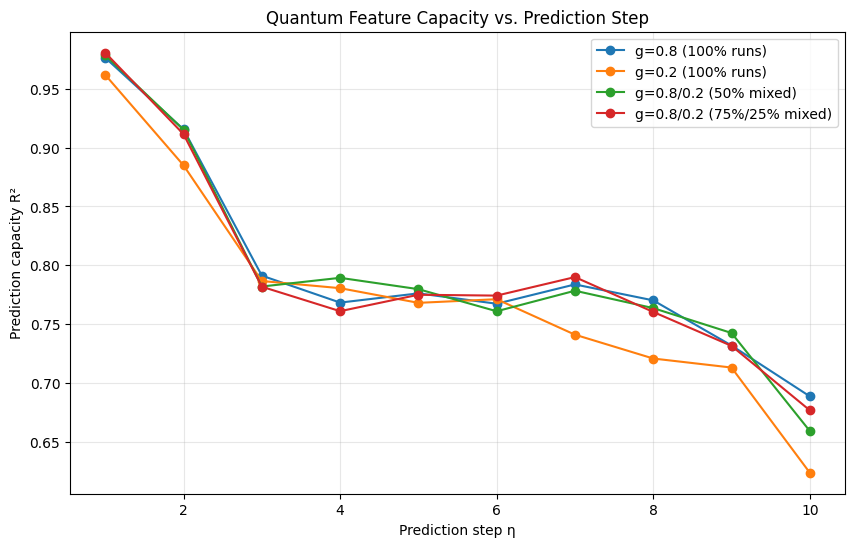

Capacity curves saved to: results_rwp_Nwo_16_20250606_223914/capacity_curves.png

===== All Operations Completed =====
Total elapsed time: 578248.37 seconds


In [28]:
# Calculate prediction capacity (for 4 curves)
print("\n===== Calculating Prediction Capacity =====")
curve_configs = [
    ("feats_g08_R100", "g=0.8 (100% runs)"),
    ("feats_g02_R100", "g=0.2 (100% runs)"),
    ("mixed_50_08_50_02", "g=0.8/0.2 (50% mixed)"),
    ("mixed_75_08_25_02", "g=0.8/0.2 (75%/25% mixed)")
]

available_curves = []
for key, label in curve_configs:
    data = results.get(key) if key in results else merged_features.get(key)
    if data is not None:
        available_curves.append((key, label, data))
    else:
        print(f"Warning: Data for curve '{label}' missing (key={key}), skipping")

if available_curves:
    max_eta = 10
    etas = range(1, max_eta + 1)
    capacity_results = {"etas": list(etas)}

    for key, label, data in available_curves:
        try:
            curve = [compute_capacity(data, TIME_SERIES, e, True)[1] for e in etas]
            capacity_results[label] = [float(v) for v in curve]
            print(f"Capacity calculation completed for: {label}")
        except Exception as e:
            print(f"Capacity calculation failed for {label}: {e}")

    capacity_path = os.path.join(output_dir, "capacity_results.json")
    with open(capacity_path, "w") as f:
        json.dump(capacity_results, f, indent=4)
    print(f"Capacity results saved to: {capacity_path}")

    plt.figure(figsize=(10, 6))
    for key, label, data in available_curves:
        if label in capacity_results:
            plt.plot(etas, capacity_results[label], marker='o', label=label)

    plt.xlabel('Prediction step η')
    plt.ylabel('Prediction capacity R²')
    plt.title('Quantum Feature Capacity vs. Prediction Step')
    plt.legend()
    plt.grid(alpha=0.3)
    plot_path = os.path.join(output_dir, "capacity_curves.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Capacity curves saved to: {plot_path}")
else:
    print("Warning: No available data, skipping capacity calculation")

total_duration = time.time() - start_time
print(f"\n===== All Operations Completed =====")
print(f"Total elapsed time: {total_duration:.2f} seconds")

In [14]:
def measure_z_batch_proj(rhos, N, device):
    """Z-basis projective measurement (returns spin values -1/1)"""
    with autocast(device_type='cuda' if device.type == 'cuda' else 'cpu'):
        batch_size, dim, _ = rhos.shape
        assert dim == 2 ** N, f"Number of qubits N={N} does not match density matrix dimension dim={dim} (requires dim=2^N)"

        # Calculate diagonal probabilities (probability distribution of measurement results)
        diag_probs = torch.diagonal(rhos, dim1=-2, dim2=-1).real
        diag_probs = torch.clamp(diag_probs, min=0.0)  # Ensure non-negative probabilities
        diag_probs /= diag_probs.sum(dim=1, keepdim=True)  # Normalize probabilities

        # Sample measurement results (basis state indices)
        ks = torch.multinomial(diag_probs, num_samples=1, replacement=True).squeeze(1)

        # Basis state index → spin values (binary decoding)
        shift = torch.arange(N - 1, -1, -1, device=device, dtype=torch.int32)  # Shift amounts (from high to low bits)
        bits = (ks.unsqueeze(1) >> shift) & 1  # Extract binary bits (0 or 1)
        spins = 2 * bits.float() - 1  # Convert to spin values (0→-1, 1→1)
        return spins

In [15]:
def precompute_fixed_matrices(total_spins, T_evolution, H_field, J_base, device):
    """Precompute basis transformation matrices and evolution operators (independent of N_wo)"""
    # Basis transformation matrices
    X_change, Y_change, X_change_dag, Y_change_dag = gen_basis_change_mats(total_spins, device)
    # Hamiltonian and evolution operators
    H = build_hamiltonian(total_spins, H_field, J_base, device)
    U, U_dag = compute_time_evolution(H, T_evolution, device)
    return X_change, Y_change, X_change_dag, Y_change_dag, U, U_dag

In [16]:
def simulate_features_xyz_RWP(time_series, total_spins, U, U_dag, X_change, Y_change, X_change_dag, Y_change_dag, N_wo,N_meas, device):
    """Optimized RWP simulation function (batch matrix multiplication + vectorized loop)"""
    T = len(time_series)
    dim = 2 ** total_spins
    ts_tensor = torch.tensor(time_series, dtype=torch.float32, device=device)
    sum_spins = torch.zeros((3, T, total_spins), dtype=torch.float32,
                            device=device)  # Store spin means for each basis (3 bases × T time steps × N spins)
    sum_spins_cov = torch.zeros((3, T, total_spins, total_spins), dtype=torch.float32,
                                device=device)  # Store spin covariances
    start_total = time.time()  # Total timing start

    # Precompute batch evolution operators (N_meas identical U)
    U_batch = U.unsqueeze(0).repeat(N_meas, 1, 1)  # Shape: (N_meas, dim, dim)
    U_dag_batch = U_dag.unsqueeze(0).repeat(N_meas, 1, 1)

    for t in range(T):
        # Print progress every 500 steps
        if (t + 1) % 500 == 0:
            print(f"[RWP] Processing time step {t + 1}/{T} (rewind window={N_wo})")

        start = max(0, t - N_wo)  # Rewind window start
        window_len = t - start + 1  # Window length

        # Quantum State Evolution (Rewind Window Processing)
        if start > 0:
            # Initialize batch density matrices (N_meas independent samples)
            rho0 = torch.zeros((N_meas, dim, dim), dtype=torch.complex64, device=device)
            rho0[:, 0, 0] = 1.0  # Initial state: |0...0⟩

            # Extract s_k sequence within window (vectorized)
            s_k_window = ts_tensor[start:t + 1]  # Shape: (window_len,)

            # Time-step evolution (vectorized processing)
            for s in range(window_len):
                s_k = s_k_window[s]
                # Construct local density matrix rho_A (N_meas×2×2)
                rho_A = torch.stack([
                                        torch.tensor([[1 - s_k, torch.sqrt((1 - s_k) * s_k)],
                                                      [torch.sqrt((1 - s_k) * s_k), s_k]], dtype=torch.complex64,
                                                     device=device)
                                    ] * N_meas, dim=0)  # Shape: (N_meas, 2, 2)

                # Calculate density matrix of remaining system (partial trace)
                rho_rest = partial_trace(rho0, n_trace=1, keep_first=False)  # Shape: (N_meas, dim//2, dim//2)

                # Tensor product: rho_A ⊗ rho_rest → (N_meas, 2*dim//2, 2*dim//2) = (N_meas, dim, dim)
                rho0 = torch.einsum('bij,bkl->bikjl', rho_A, rho_rest).reshape(N_meas, 2 * (dim // 2), 2 * (dim // 2))

                # Apply time evolution operator (batch matrix multiplication)
                rho0 = torch.bmm(torch.bmm(U_batch, rho0), U_dag_batch)  # Shape remains (N_meas, dim, dim)
            rhos = rho0  # Final evolved batch density matrices
        else:
            # No rewind window: use initial state directly (N_meas samples)
            rhos = torch.zeros((N_meas, dim, dim), dtype=torch.complex64, device=device)
            rhos[:, 0, 0] = 1.0

        # ------------------------- Three-Basis Measurement and Statistics -------------------------
        # Z-basis measurement
        spins_z = measure_z_batch_proj(rhos, total_spins, device)  # Shape: (N_meas, total_spins)
        sum_spins[0, t] = spins_z.mean(dim=0)  # Spin mean
        sum_spins_cov[0, t] = torch.cov(spins_z.T)  # Spin covariance

        # X-basis measurement (first transform to Z basis)
        rhos_x = torch.bmm(torch.bmm(X_change.unsqueeze(0).repeat(N_meas, 1, 1), rhos),
                           X_change_dag.unsqueeze(0).repeat(N_meas, 1, 1))
        spins_x = measure_z_batch_proj(rhos_x, total_spins, device)
        sum_spins[1, t] = spins_x.mean(dim=0)
        sum_spins_cov[1, t] = torch.cov(spins_x.T)

        # Y-basis measurement (first transform to Z basis)
        rhos_y = torch.bmm(torch.bmm(Y_change.unsqueeze(0).repeat(N_meas, 1, 1), rhos),
                           Y_change_dag.unsqueeze(0).repeat(N_meas, 1, 1))
        spins_y = measure_z_batch_proj(rhos_y, total_spins, device)
        sum_spins[2, t] = spins_y.mean(dim=0)
        sum_spins_cov[2, t] = torch.cov(spins_y.T)

    # Calculate total execution time and output
    total_duration = time.time() - start_total
    print(f"\nN_wo={N_wo} Total execution time: {total_duration:.2f} seconds")

    # Convert to numpy and construct feature dataframe
    sum_spins_np = sum_spins.cpu().numpy()
    sum_cov_np = sum_spins_cov.cpu().numpy()
    i_up, j_up = np.triu_indices(total_spins, k=1)  # Upper triangular indices (avoid duplication)
    features = []
    for basis in range(3):  # Iterate over X/Y/Z bases
        mean = sum_spins_np[basis]  # Mean features (T×total_spins)
        cov = sum_cov_np[basis, :, i_up, j_up].T  # Covariance features (T×(total_spins*(total_spins-1)/2))
        features.append(np.hstack([mean, cov]))  # Concatenate mean and covariance
    return pd.DataFrame(np.hstack(features))  # Final feature dataframe (T×total_features)

In [20]:
N_meas_rwp = 50000  # Number of samples per measurement
MAX_ETA = 10  # Maximum prediction step
T_evolution = 10  # Evolution time
N_wo_list = [2, 4, 8, 10,16]  # List of rewind window sizes to test
timestamp = time.strftime("%Y%m%d_%H%M%S")  # Timestamp (for file naming)

In [21]:
# Precompute fixed matrices (independent of N_wo, only compute once)
(X_change, Y_change, X_change_dag, Y_change_dag,
 U, U_dag) = precompute_fixed_matrices(TOTAL_SPINS, T_evolution, H_FIELD, J_BASE, device)

# Store feature data for different N_wo
features_dict = {}

# Loop through different rewind window sizes N_wo
for N_wo in N_wo_list:
    print(f"\n========== Starting simulation for N_wo={N_wo} ==========")
    # Run RWP simulation
    features_rwp = simulate_features_xyz_RWP(
        time_series=TIME_SERIES,
        total_spins=TOTAL_SPINS,
        U=U,
        U_dag=U_dag,
        X_change=X_change,
        Y_change=Y_change,
        X_change_dag=X_change_dag,
        Y_change_dag=Y_change_dag,
        N_wo=N_wo,
        N_meas=N_meas_rwp,
        device=device
    )
    # Save feature data to independent directory
    output_dir = f"results_rwp_Nwo_{N_wo}_{timestamp}"
    os.makedirs(output_dir, exist_ok=True)
    save_path = os.path.join(output_dir, "rwp_features.csv")
    features_rwp.to_csv(save_path, index=False)
    print(f"Saved features for N_wo={N_wo} to: {save_path}")
    features_dict[N_wo] = features_rwp  # Store feature data for plotting


========== Starting simulation for N_wo=2 ==========
[RWP] Processing time step 500/2000 (rewind window=2)
[RWP] Processing time step 1000/2000 (rewind window=2)
[RWP] Processing time step 1500/2000 (rewind window=2)
[RWP] Processing time step 2000/2000 (rewind window=2)

N_wo=2 Total execution time: 264.01 seconds
Saved features for N_wo=2 to: results_rwp_Nwo_2_20250606_223914/rwp_features.csv

========== Starting simulation for N_wo=4 ==========
[RWP] Processing time step 500/2000 (rewind window=4)
[RWP] Processing time step 1000/2000 (rewind window=4)
[RWP] Processing time step 1500/2000 (rewind window=4)
[RWP] Processing time step 2000/2000 (rewind window=4)

N_wo=4 Total execution time: 384.37 seconds
Saved features for N_wo=4 to: results_rwp_Nwo_4_20250606_223914/rwp_features.csv

========== Starting simulation for N_wo=8 ==========
[RWP] Processing time step 500/2000 (rewind window=8)
[RWP] Processing time step 1000/2000 (rewind window=8)
[RWP] Processing time step 1500/2000 (r

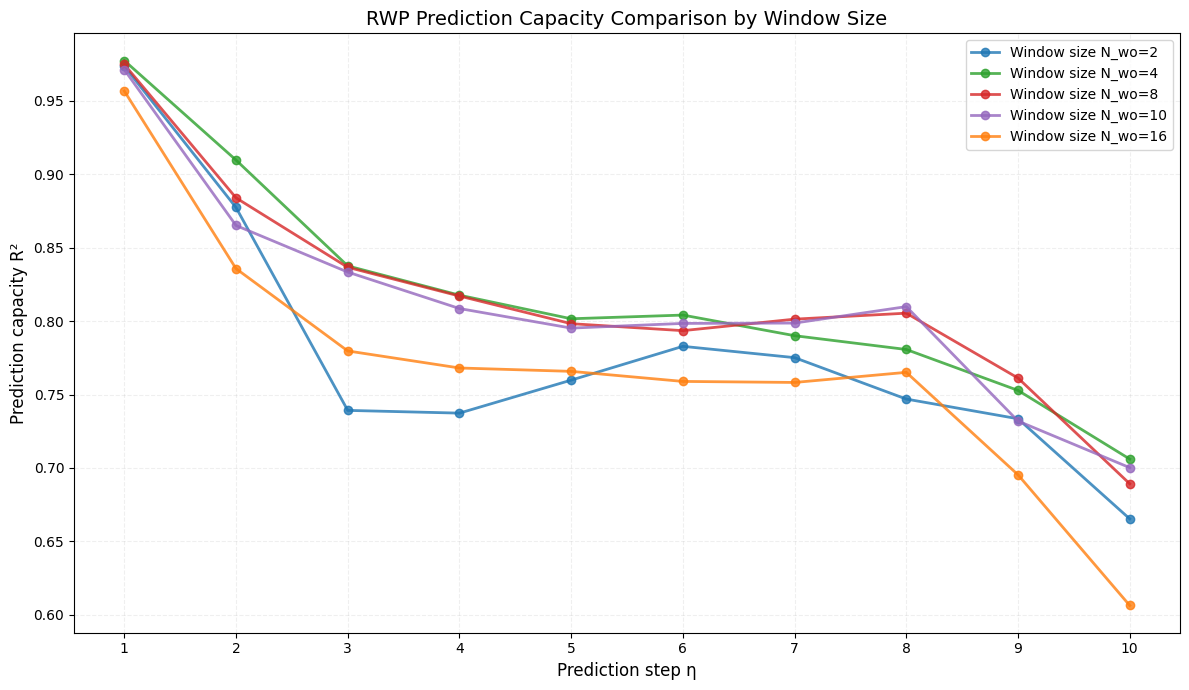

In [23]:
# Plot prediction capacity comparison for different N_wo
etas = range(1, MAX_ETA + 1)  # Prediction steps η=1 to 10
colors = [
    '#1f77b4',  
    '#2ca02c',  
    '#d62728',  
    '#9467bd',
    '#ff7f0e' 
]
     # Color scheme

plt.figure(figsize=(12, 7))
for idx, (N_wo, features) in enumerate(features_dict.items()):
    # Calculate test set R² for each η
    curve_r2 = [compute_capacity(features, TIME_SERIES, e, True)[1] for e in etas]
    # Plot curve
    plt.plot(etas, curve_r2, marker='o', linewidth=2, color=colors[idx],
             label=f'Window size N_wo={N_wo}', alpha=0.8)

plt.xlabel('Prediction step η', fontsize=12)
plt.ylabel('Prediction capacity R²', fontsize=12)
plt.title('RWP Prediction Capacity Comparison by Window Size', fontsize=14)
plt.xticks(etas, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(alpha=0.2, linestyle='--')
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig(f"capacity_comparison_{timestamp}.png", dpi=300)  # Save high-resolution plot
plt.show()

In [24]:
def load_olp_features(olp_dir):
    """Load OLP feature files from directory"""
    curve_configs = [
        ("feats_g02_R100.csv", "OLP: g=0.2 (100% runs)"),
        ("feats_g08_R100.csv", "OLP: g=0.8 (100% runs)"),
        ("mixed_50_08_50_02.csv", "OLP: g=0.8/0.2 (50% mixed)"),
        ("mixed_75_08_25_02.csv", "OLP: g=0.8/0.2 (75%/25% mixed)")
    ]
    available_curves = []
    for filename, label in curve_configs:
        file_path = os.path.join(olp_dir, filename)
        if os.path.exists(file_path):
            features = pd.read_csv(file_path)
            available_curves.append((label, features))
            print(f"Loaded OLP feature: {label}")
        else:
            print(f"Warning: OLP file {filename} not found, skipping {label}")
    return available_curves

In [25]:
def load_rwp_features(rwp_base_dir, timestamp, N_wo_list):
    """Load RWP feature files from timestamped directories"""
    features_dict = {}
    for N_wo in N_wo_list:
        dir_path = f"{rwp_base_dir}/results_rwp_Nwo_{N_wo}_{timestamp}"
        file_path = os.path.join(dir_path, "rwp_features.csv")
        if os.path.exists(file_path):
            features = pd.read_csv(file_path)
            features_dict[N_wo] = features
            print(f"Loaded RWP feature: N_wo={N_wo}")
        else:
            print(f"Warning: RWP directory {dir_path} not found, skipping N_wo={N_wo}")
    return features_dict

In [26]:
MAX_ETA = 10
etas = range(1, MAX_ETA + 1)

OLP_DIR = f"./results_20250531_223909" 
RWP_BASE_DIR = "."  
timestamp = "20250606_223914"  

olp_curves = load_olp_features(OLP_DIR)
rwp_features = load_rwp_features(RWP_BASE_DIR, timestamp, N_wo_list)

Loaded OLP feature: OLP: g=0.2 (100% runs)
Loaded OLP feature: OLP: g=0.8 (100% runs)
Loaded OLP feature: OLP: g=0.8/0.2 (50% mixed)
Loaded OLP feature: OLP: g=0.8/0.2 (75%/25% mixed)
Loaded RWP feature: N_wo=2
Loaded RWP feature: N_wo=4
Loaded RWP feature: N_wo=8
Loaded RWP feature: N_wo=10
Loaded RWP feature: N_wo=16


In [36]:
olp_capacities = {}
for label, features in olp_curves:
    curve1 = [compute_capacity(features, TIME_SERIES, e, True)[1] for e in etas]
    olp_capacities[label] = curve1
rwp_capacities = {}
for N_wo, features in rwp_features.items():
    curve2 = [compute_capacity(features, TIME_SERIES, e, True)[1] for e in etas]
    rwp_capacities[N_wo] = curve2

In [37]:
 olp_capacities,rwp_capacities

({'OLP: g=0.2 (100% runs)': [np.float64(0.9618090101065796),
   np.float64(0.8848859476627408),
   np.float64(0.7865694601842269),
   np.float64(0.7804831331524119),
   np.float64(0.7680039411451361),
   np.float64(0.7710984960983256),
   np.float64(0.7409345883863889),
   np.float64(0.7206708375284505),
   np.float64(0.7129981941836087),
   np.float64(0.6235891057865268)],
  'OLP: g=0.8 (100% runs)': [np.float64(0.9763777506758238),
   np.float64(0.915463200027319),
   np.float64(0.791144900672919),
   np.float64(0.7682143744157285),
   np.float64(0.7760598779085551),
   np.float64(0.7672572268100863),
   np.float64(0.7836702062670939),
   np.float64(0.7701077923220646),
   np.float64(0.7317353994060165),
   np.float64(0.6885255782568019)],
  'OLP: g=0.8/0.2 (50% mixed)': [np.float64(0.978450867607233),
   np.float64(0.915159852534922),
   np.float64(0.7818848185540673),
   np.float64(0.789273195879066),
   np.float64(0.7796400870923712),
   np.float64(0.7608485722415862),
   np.float

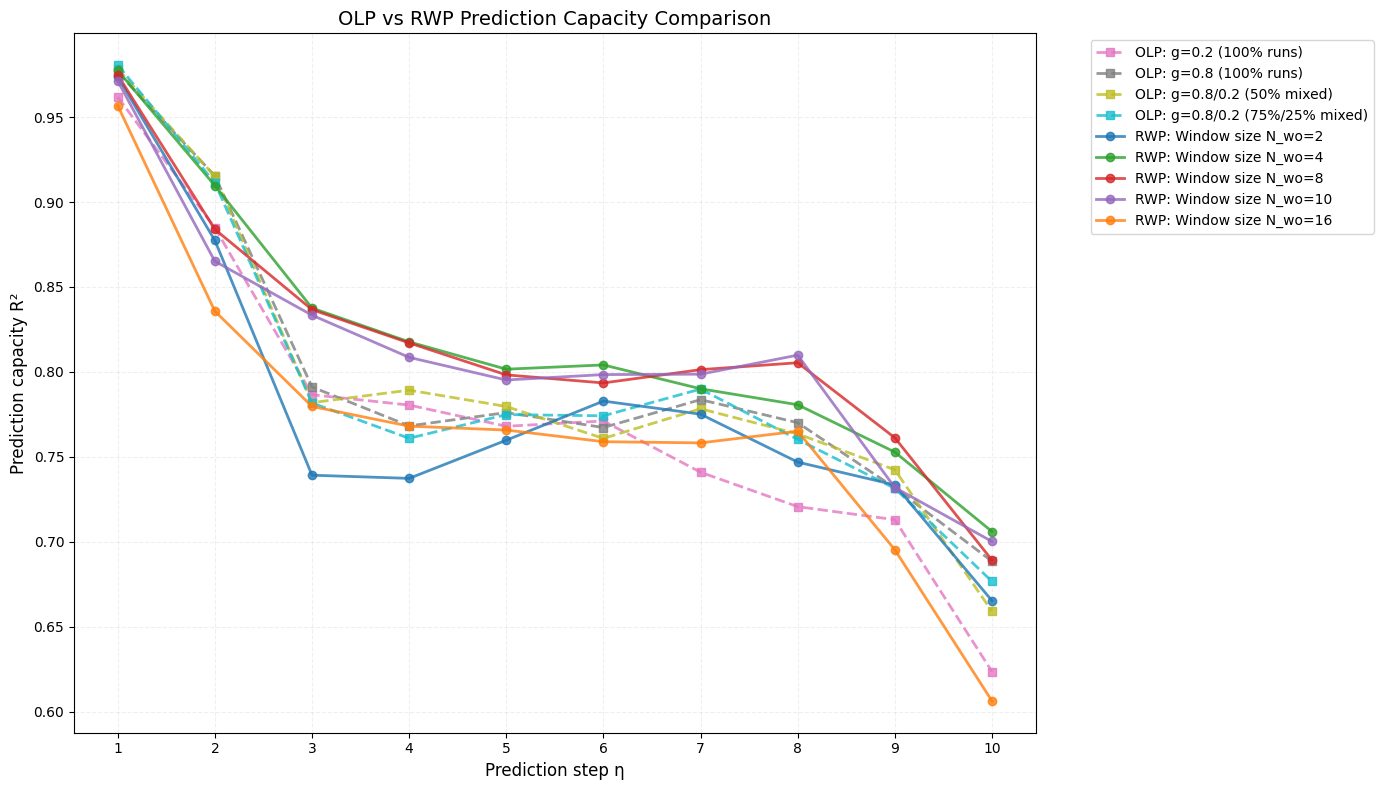

In [39]:
plt.figure(figsize=(14, 8))

olp_colors = ['#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
for idx, (label, curve) in enumerate(olp_capacities.items()):
    plt.plot(etas, curve, marker='s', linestyle='--',
             linewidth=2, color=olp_colors[idx],
             label=label, alpha=0.8)

rwp_colors = ['#1f77b4', '#2ca02c', '#d62728', '#9467bd', '#ff7f0e']
for idx, (N_wo, curve) in enumerate(rwp_capacities.items()):
    plt.plot(etas, curve, marker='o', linestyle='-',
             linewidth=2, color=rwp_colors[idx],
             label=f'RWP: Window size N_wo={N_wo}', alpha=0.8)

plt.xlabel('Prediction step η', fontsize=12)
plt.ylabel('Prediction capacity R²', fontsize=12)
plt.title('OLP vs RWP Prediction Capacity Comparison', fontsize=14)
plt.xticks(etas, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(alpha=0.2, linestyle='--')
plt.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f"combined_olp_rwp_capacity_{timestamp}.png", dpi=300, bbox_inches='tight')
plt.show()